# 사전 준비
1. 데이터셋을 다운받고 원하는 구글 드라이브 원하는 경로에 업로드합니다. [dataset.zip 다운로드](https://drive.google.com/file/d/1fvgQOp_gHEabCf-qAXqe7ZPg2Sj_FM_J/view?usp=sharing)
2. 구글 드라이브에 마운트하여 구글 드라이브 경로에 접근 가능하도록 합니다.


In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


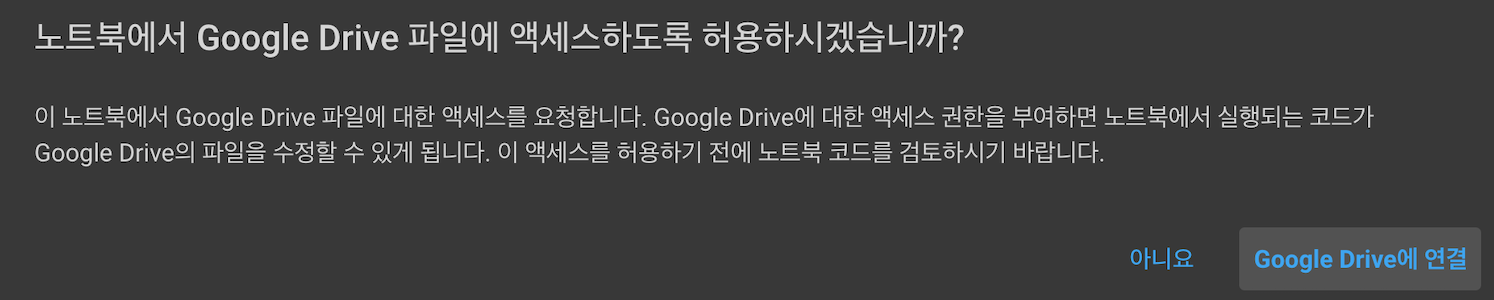

- 코드 실행 후 본인 계정으로 Google Drive에 연결을 허용합니다.
- 마운트가 완료되면 좌측 폴더 버튼을 통해 구글 드라이브에 접근할 수 있습니다.

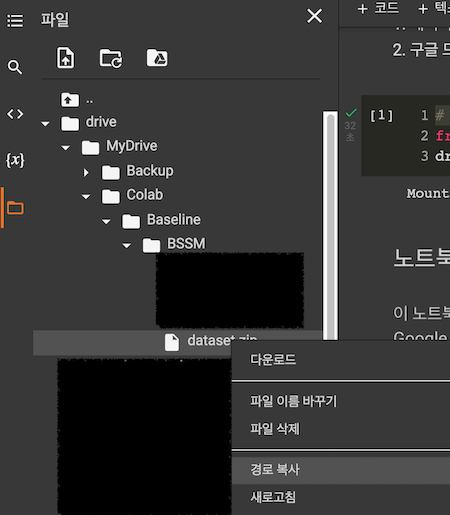

- 사진과 같이 본인이 업로드한 경로에 접근하여 dataset.zip 파일의 경로를 복사합니다. 

- unzip 명령어를 통해 dataset.zip 압축 파일을 현재 경로에 해제합니다.
`!unzip {압축 파일 경로} -d {현재 경로}`
- dataset 폴더가 생성되고 폴더 내부에 train.csv, test.csv, submit_sample.csv 파일이 생성된 것을 확인할 수 있습니다.

In [ ]:
!unzip /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip -d ./

Archive:  /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip
   creating: ./dataset/
  inflating: ./dataset/submit_sample.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     


In [234]:
# 테이블 형식의 데이터를 처리하는 pandas 라이브러리를 임포트
import pandas as pd

In [254]:
# train.csv, test.csv 파일을 DataFrame 형태로 읽어옵니다.
train_df = pd.read_csv('/content/drive/MyDrive/datathon/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datathon/dataset/test.csv')
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)

train shape:  (9375, 10)
test shape:  (4018, 9)


In [ ]:
# train.csv는 총 9375개의 행과 10개의 열로 구성되어있습니다.
# 10개 열 중에서 마지막 열("body fat_%")은 예측해야 할 체지방율을 나타냅니다. 
train_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,body fat_%
0,23.0,M,173.7,87.0,143.0,52.9,18.0,57.0,233.0,12.7
1,24.0,M,181.6,65.0,126.0,45.1,8.3,38.0,254.0,3.5
2,36.0,F,166.5,84.0,130.0,27.4,18.9,40.0,186.0,25.9
3,22.0,F,165.8,77.0,130.0,29.7,19.0,30.0,183.0,33.0
4,61.0,F,144.7,77.0,130.0,20.7,11.8,7.0,126.0,28.3


In [255]:
# test.csv에는 체지방율 정보("body fat_%")는 없으며, 체지방율 예측을 위한 feature 정보 9개만 제공됩니다.
test_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,42.0,M,158.7,93.0,145.0,35.0,16.1,45.0,208.0
1,25.0,M,171.6,96.0,137.0,50.2,13.6,47.0,211.0
2,31.0,M,169.2,74.0,119.0,57.5,18.9,60.0,250.0
3,39.0,M,170.7,72.0,138.0,43.5,18.7,42.0,222.0
4,57.0,F,167.2,73.0,126.0,17.5,-3.4,0.0,65.0


In [256]:
# train_df에서 체지방율 열을 pop 하여 y_train에 저장합니다.
y_train = train_df.pop('body fat_%')

print(train_df.shape)
print(y_train.shape)

(9375, 9)
(9375,)


In [257]:
# 베이스라인 코드에서는 성별(카테고리 데이터)을 제외하고 수치 데이터만 활용해 봅니다.
# 학습 및 평가 셋에 각각 성별(gender)을 제거해줍니다.
train_df['gender'] = train_df['gender'].map({'M':0, 'F':1})
test_df['gender'] = test_df['gender'].map({'M':0, 'F':1})

#정규화를 위해서 gender field 분리
train_gtemp = train_df.pop('gender')
test_gtemp = test_df.pop('gender')

print(train_df.info())
print(test_df.info())
print(train_gtemp.head())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9375 entries, 0 to 9374
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      9375 non-null   float64
 1   height_cm                9375 non-null   float64
 2   diastolic                9375 non-null   float64
 3   systolic                 9375 non-null   float64
 4   gripForce                9375 non-null   float64
 5   sit and bend forward_cm  9375 non-null   float64
 6   sit-ups counts           9375 non-null   float64
 7   broad jump_cm            9375 non-null   float64
dtypes: float64(8)
memory usage: 586.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      4018 non-null   float64
 1   height_cm                4018 non-

In [258]:
# 8개 컬럼의 수치 데이터를 정규화 하여 학습 가능한 형태로 재가공 합니다.
# 다른 정규화 방식을 찾아서 적용해보고 정규화 방식에 따라 결과가 어떻게 달라지는지 확인해봅니다.
from sklearn.preprocessing import StandardScaler 

# 학습 및 평가 데이터를 DataFrame 형태로 입력받아 정규화된 데이터로 변환하는 함수 
def scale(x_train, x_test):
    columns = x_train.columns

    scaler = StandardScaler()

    # 학습 데이터의 age ~ broad jump_cm 열에 해당하는 값을 가져와 피팅 시킵니다.
    scaler.fit(x_train)

    # 피팅된 scaler를 기준으로 학습데이터를 정규화합니다.
    x_train = scaler.transform(x_train)
    # 평가 데이터도 마찬가지로 학습 데이터로 피팅된 scaler를 기준으로 정규화를 진행합니다.
    x_test = scaler.transform(x_test)

    # DataFrame 형태로 변환하여 반환합니다.
    x_train = pd.DataFrame(columns=columns, data=x_train)
    x_test = pd.DataFrame(columns=columns, data=x_test)

    return x_train, x_test

# 학습 데이터, 평가 데이터를 정의한 scale 함수에 전달하여 정규화된 학습 및 평가 데이터를 x_train, x_test에 저장합니다.
x_train, x_test = scale(train_df, test_df)

In [259]:
x_train['gender'] = train_gtemp
x_test['gender'] = test_gtemp

x_train['gender'] = x_train['gender'].astype('bool')
x_test['gender'] = x_test['gender'].astype('bool')

In [244]:
x_train1 = x_train
y_train1 = y_train

In [260]:
# 정규화된 데이터를 확인
x_train1.info()
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9375 entries, 0 to 9374
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      9375 non-null   float64
 1   height_cm                9375 non-null   float64
 2   diastolic                9375 non-null   float64
 3   systolic                 9375 non-null   float64
 4   gripForce                9375 non-null   float64
 5   sit and bend forward_cm  9375 non-null   float64
 6   sit-ups counts           9375 non-null   float64
 7   broad jump_cm            9375 non-null   float64
 8   gender                   9375 non-null   bool   
dtypes: bool(1), float64(8)
memory usage: 595.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9375 entries, 0 to 9374
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      9375 

In [251]:
y_train1.head()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      4018 non-null   float64
 1   height_cm                4018 non-null   float64
 2   diastolic                4018 non-null   float64
 3   systolic                 4018 non-null   float64
 4   gripForce                4018 non-null   float64
 5   sit and bend forward_cm  4018 non-null   float64
 6   sit-ups counts           4018 non-null   float64
 7   broad jump_cm            4018 non-null   float64
 8   gender                   4018 non-null   bool   
dtypes: bool(1), float64(8)
memory usage: 255.2 KB


In [252]:
x_train.describe()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03
mean,-2.471682e-16,3.060912e-15,1.185185e-16,1.105072e-16,-5.359328e-16,-3.569293e-17,1.123013e-16,2.941647e-16
std,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00
min,-1.163953e+00,-5.166366e+00,-7.330272e+00,-8.879951e+00,-3.471422e+00,-4.100997e+00,-2.800783e+00,-4.760953e+00
25%,-8.706477e-01,-7.319014e-01,-7.307801e-01,-7.092328e-01,-8.898338e-01,-5.046425e-01,-6.204665e-01,-7.055096e-01
50%,-3.573633e-01,8.622181e-02,1.282470e-02,-2.833968e-02,8.647590e-02,1.238465e-01,8.286141e-02,9.556560e-02
75%,8.158583e-01,7.264922e-01,6.634789e-01,7.206428e-01,7.717702e-01,6.475874e-01,7.158566e-01,7.714728e-01
max,1.989080e+00,2.991152e+00,7.188611e+00,4.806002e+00,3.146831e+00,2.301714e+01,2.685175e+00,2.824228e+00


In [261]:
# 학습을 수행하기 전에 모델 학습이 제대로 진행되었는지 확인하기 위해 검증셋을 분리해 놓습니다.
# 검증셋은 학습에 사용하지 않고 모델을 평가하기 위해 사용됩니다.
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(7500, 9) (7500,)
(1875, 9) (1875,)


In [66]:
#모델 추가
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [262]:
#모델 객체 생성
model_dic = {
    "Linear" : LinearRegression(),
    "SVM" : svm.SVR(),
    "RandomForest" : RandomForestRegressor(),
    "xgboost" : XGBRegressor() 
}

#"xgboost" : XGBRegressor() 

In [202]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 8781 to 3843
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      4800 non-null   float64 
 1   height_cm                4800 non-null   float64 
 2   diastolic                4800 non-null   float64 
 3   systolic                 4800 non-null   float64 
 4   gripForce                4800 non-null   float64 
 5   sit and bend forward_cm  4800 non-null   float64 
 6   sit-ups counts           4800 non-null   float64 
 7   broad jump_cm            4800 non-null   float64 
 8   gender                   4800 non-null   category
dtypes: category(1), float64(8)
memory usage: 342.3 KB


In [263]:
model_p = {}

for key in model_dic.keys() :
  print(f'{key} : training')
  model_dic[key].fit(x_train, y_train)

  print(f'{key} : predict')
  model_p[key] = model_dic[key].predict(x_valid)

Linear : training
Linear : predict
SVM : training
SVM : predict
RandomForest : training
RandomForest : predict
xgboost : training
[05:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost : predict


In [264]:
#결과를 데이터프레임으로
model_pdf = pd.DataFrame(model_p)
model_pdf['valid'] = list(y_valid)
model_pdf

,Linear,SVM,RandomForest,xgboost,valid
0,27.273547,26.805554,22.521891,25.441582,25.7
1,18.860217,18.037724,18.064000,19.798456,13.2
2,27.364127,26.365711,26.395000,26.376348,20.9
3,17.941947,17.000604,15.945305,16.571264,24.3
4,26.718307,27.331711,28.210200,27.023787,26.5
...,...,...,...,...,...
1870,12.870647,15.731839,12.864000,13.839112,8.3
1871,21.304650,21.162889,23.034000,22.504974,25.5
1872,37.194612,36.138947,35.945800,36.084309,19.2
1873,34.135324,30.830533,31.193000,31.425833,34.1


In [123]:
def gh(col) :
  plt.plot(model_pdf.index, model_pdf['valid'], 'r-')
  plt.plot(model_pdf.index, model_pdf[col], 'b--')
  plt.title(col)

  plt.show()

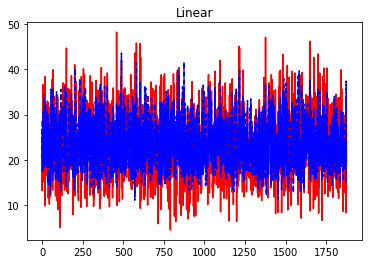

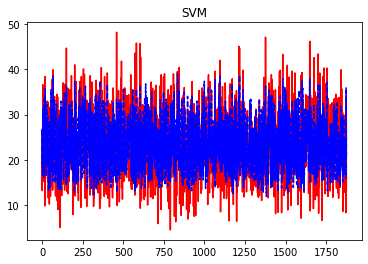

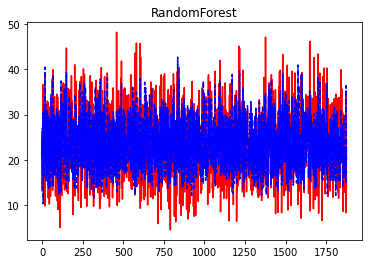

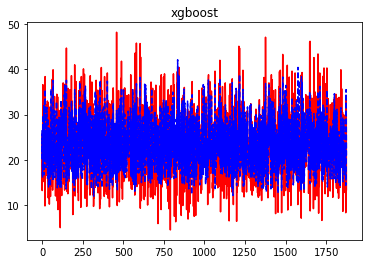

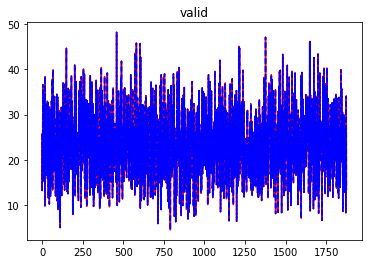

In [71]:
for col in model_pdf.columns :
  gh(col)

In [72]:
import matplotlib.pyplot as plt

In [73]:
# 검증셋 예측값(preds)과 정답(y_valid)를 그려봅니다. 
def gh1(col):
  plt.figure()
  plt.scatter(model_pdf[col], model_pdf['valid']) # x축에는 예측값, y축은 검증셋의 정답
  plt.xlabel('predict')
  plt.ylabel('label')
  plt.axis('square')
  plt.title(col)
  plt.show()

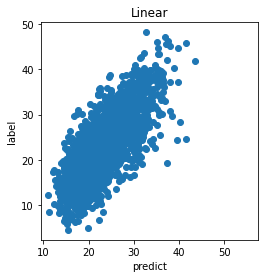

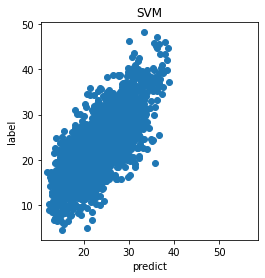

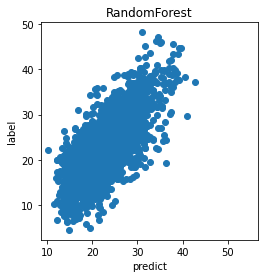

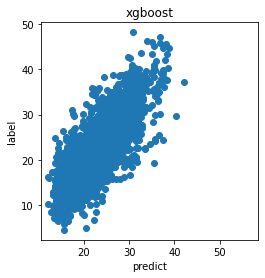

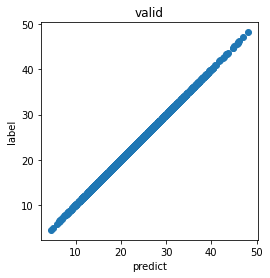

In [74]:
for col in model_pdf.columns :
  gh1(col)

In [75]:
# 학습 데이터 특징 중 신장(height_cm) 정보만 가져와 모델에 잘 피팅 되었는지 검증셋의 예측 결과와 정답을 비교해봅니다.
def findRealValue(col):
  plt.figure()
  plt.scatter(x_valid[col], model_pdf[col], color='red', alpha=0.3, label='pred')
  plt.scatter(x_valid[col], model_pdf['valid'], color='blue', alpha=0.3, label='label')
  plt.title(col)
  plt.show()

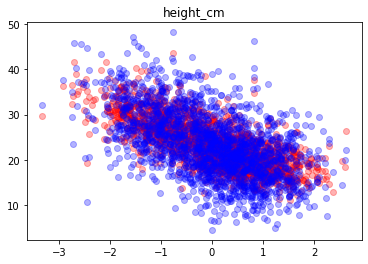

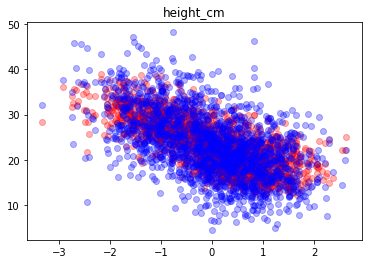

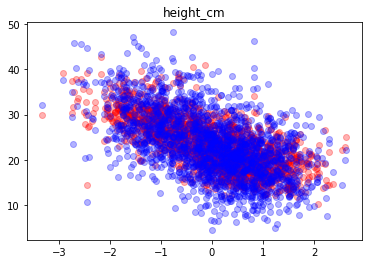

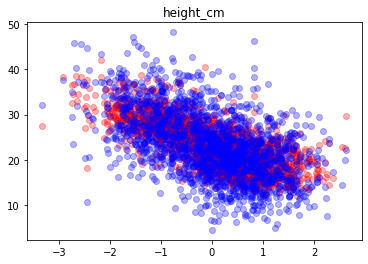

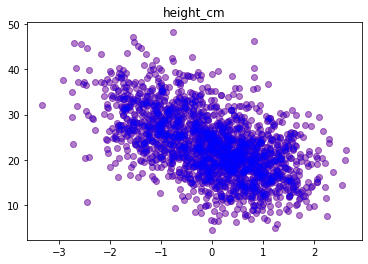

In [76]:
for col in model_pdf.columns :
  gh2(col)

# 모델평가

In [95]:
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
import numpy as np

In [265]:
model_rmse = {} 
model_r2 = {} 
model_mae = {}

for key in model_dic.keys() :
  mse = mean_squared_error(model_pdf['valid'], model_p[key])
  rmse = np.sqrt(mse)

  model_rmse[key] = rmse
  model_r2[key] = r2_score(model_pdf['valid'], model_p[key])

  mae = mean_absolute_error(model_pdf['valid'], model_p[key])
  model_mae[key] = mae
  

In [80]:
model_rmse

{'Linear': 4.866064512791702,
 'RandomForest': 4.861893112471931,
 'SVM': 4.773233431452785,
 'xgboost': 4.7768702994951555}

In [81]:
model_r2

{'Linear': 0.5439454441446188,
 'RandomForest': 0.5447270082654495,
 'SVM': 0.5611799917266825,
 'xgboost': 0.5605110370314079}

In [266]:
model_mae

{'Linear': 3.82428666325485,
 'RandomForest': 3.818286114768,
 'SVM': 3.767996808811316,
 'xgboost': 3.777044651039876}

# 평가 데이터 예측 및 제출 파일 생성

In [270]:
# 검증셋 예측과 동일하게 평가 데이터 예측을 진행합니다.
preds = model_dic['SVM'].predict(x_test)
print(preds.shape)

(4018,)


In [271]:
# 제출파일 예시 파일을 읽어와 predict 열에 평가셋 예측값을 기록하여 저장합니다.
submit = pd.read_csv('/content/drive/MyDrive/datathon/dataset/submit_sample.csv')
submit['predict'] = preds

# 제출 파일 확인
submit

,predict
0,22.158845
1,23.046414
2,16.115359
3,19.103702
4,34.979834
...,...
4013,21.301510
4014,19.544364
4015,27.444762
4016,17.428169


In [272]:
# 저장
submit.to_csv('/content/drive/MyDrive/datathon/dataset/submit.csv', index=False)